<a href="https://colab.research.google.com/github/liyin2015/computer_vision_notes/blob/master/edge_corner_shape_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Upload images from local files
from google.colab import files
uploaded = files.upload()

Saving train.png to train.png
Saving test.png to test.png


In [0]:
# Define normalize function fro gray scale image
import numpy as np
def normalize(I, min_v=None, max_v=None):
  if not min_v:
    min_v = np.min(I)
  if not max_v:
    max_v = np.max(I)
  return ((I-min_v)/(max_v-min_v))*255

In [0]:
# Use self-implemented conv2d
def conv2d(img, kernel, mode='same'):
  assert kernel.shape[0] == kernel.shape[1] and kernel.shape[0] % 2 == 1
  k = kernel.shape[0]
  pad_shape = ((0, 0), (0, 0)) # left, right, up down
  if mode == 'full':
    pad_size = k-1
    pad_shape = ((pad_size, pad_size), (pad_size, pad_size))
  elif mode == 'same':
    pad_size = (k-1) // 2
    pad_shape = ((pad_size, pad_size), (pad_size, pad_size))
    
  padded_array = np.pad(img, pad_shape, 'constant')
  out_shape = (padded_array.shape[0]-kernel.shape[0]+1,  padded_array.shape[1]-kernel.shape[1]+1)
  output_array = np.zeros(out_shape)
  
  for i in range(out_shape[0]):
    for j in range(out_shape[1]):
      temp_array = padded_array[i: i+k, j: j+k]
      output_array[i, j] = np.sum(temp_array*kernel)
  return output_array

In [0]:
# Define image loading file
import cv2
def load_image(file, mode='gray'):
  image = cv2.imread(file)
  # convert to gray scale
  if mode == 'gray':
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image


[array([0.12435115, 0.20791042, 0.12435115]), array([0.20791042, 0.46575961, 0.20791042]), array([0.12435115, 0.20791042, 0.12435115])] [0.45661271 0.88158044 0.45661271] 1.7948058584616815


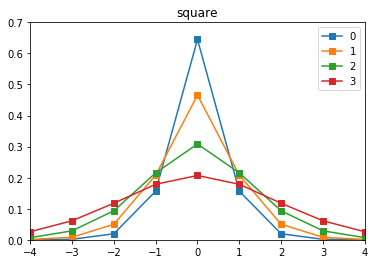

In [0]:
# Define discrete gaussian kernel
import math
import numpy as np
from scipy import special
from matplotlib import pyplot as plt

def kernel(t, n):
    return math.exp(-t) * special.iv(n, t)
ns = np.arange(-5, 5+1)
y0 = kernel(0.5, ns)
y1 = kernel(1, ns)
y2 = kernel(2, ns)
y3 = kernel(4, ns)
plt.plot(ns, y0, ns, y1, ns, y2, ns, y3, marker='s')
plt.legend(('0', '1', '2', '3'), loc='upper right')
plt.title('square')
plt.xlim([-4, 4])
plt.ylim([0, 0.7])
nmatrix = np.array([[1.4, 1, 1.4], [1, 0, 1], [1.4, 1, 1,4]])
y4 = [[] for _ in range(3)]
y4[0] = y4[2] = kernel(1, [1.4, 1, 1.4])
y4[1] = kernel(1, [1, 0, 1])
print(y4, np.sum(y4, axis=0), np.sum(y4))

In [0]:
# simple discrete gaussian kernel
import scipy
def gauss_kernel(size):
  assert size % 2 == 1, "Please make sure kernel size is odd * odd"
  k = size // 2
  x, y = scipy.mgrid[-k:k+1, -k:k+1]
  g = np.exp(-(x**2/float(k)+y**2/float(k)))
  return g / g.sum()

In [0]:
print(gauss_kernel(3))

[[0.04491922 0.12210311 0.04491922]
 [0.12210311 0.33191066 0.12210311]
 [0.04491922 0.12210311 0.04491922]]


## Canny Edge Detector, Edge linking, 30pts


1. (10pts) Write a gradient based edge detector. Your code should load in a gray-scale image (use imread and convert to a double array using im2double). You can display the image using functionality like imagesc. 

I will first implement the **canny edge detection** myself, and then compare it with the implementation in `OpenCV` library, `cv2.canny()`.

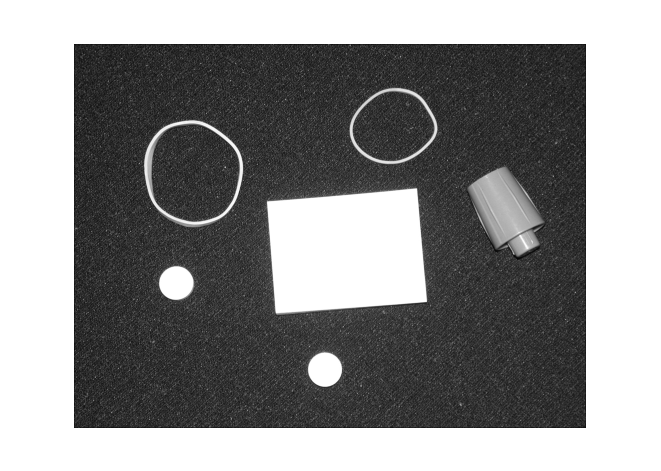

In [0]:
import cv2
from google.colab.patches import cv2_imshow
image = load_image('1.png')
cv2_imshow(image)

### Step1 : Gaussian Smoothing
Once you have loaded in the image, you should smooth the image with a Gaussian filter and then compute horizontal and vertical derivatives using a derivative filter. The amount of smoothing is determined by the parameter σ of the Gaussian (which should be a parameter in your code). You can use conv2 to perform the required convolutions, or use your own implementation from HW1. 

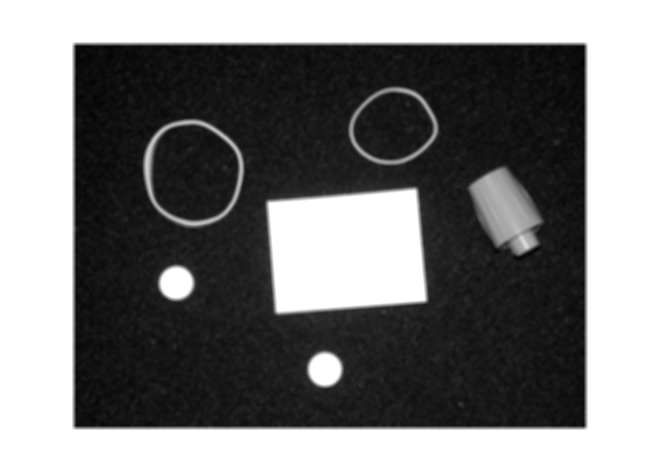

In [0]:
# Smooth the image with gaussian convolution
sigma = 3
k = 5
blur = cv2.GaussianBlur(image,(k, k),sigma)
cv2_imshow(normalize(blur))

Once you have computed the derivatives in the `x` and `y` directions, compute the gradient magnitude and orientation. Display the gradient magnitude as a image and the orientation using quiver functionality.

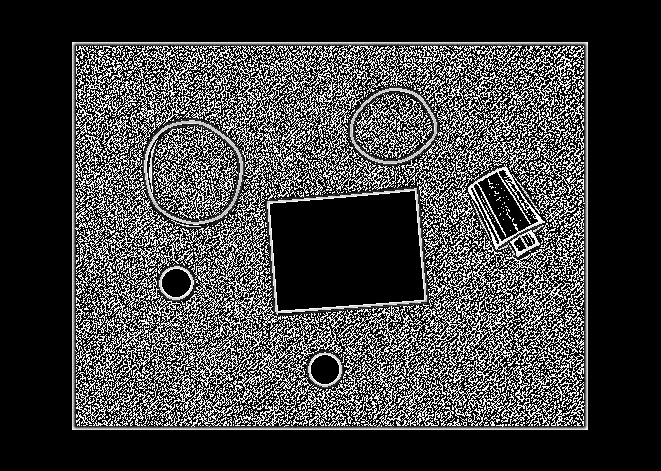

In [0]:
# Try subtraction to detect edge
cv2_imshow(normalize(blur-image))

### Step 2: Sober Operator
Sober operator uses two $3\times 3$ kernels which are convolved with the original image to caculate approximate of the derivatives. Therefore, peaks should be where the edges are. However, the edge detection is extremely sensitive to noise, thus making the usage of smooting/filtering a must in edge detection. 

In [0]:
def soberOperator(I):
  '''
  return Ix, Iy, maginitude, and orientation
  '''
  # Define Sober Kernel
  G_x = np.array([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]], dtype=np.float32)
  G_y = np.array([[-1, -2, -1],
                  [0, 0, 0],
                  [1, 2, 1]], dtype=np.float32)

  # Implement convolution with cv2
  # gx = cv2.filter2D(blur,-1,G_x)
  # gy = cv2.filter2D(blur,-1,G_y)
  # For some reason, the cv2.filter2D is giving out a wrong result
  gx = conv2d(I, G_x, mode='same' )
  gy = conv2d(I, G_y, mode='same' )

  # Normalize the image
  # ngx, ngy = np.zeros(gx.shape), np.zeros(gx.shape)
  # ngx = cv2.normalize(gx, ngx, 0, 255, cv2.NORM_MINMAX)
  # ngy = cv2.normalize(gy, ngy, 0, 255, cv2.NORM_MINMAX)

  ngx = normalize(gx)
  ngy = normalize(gy)

  # Compute the magnitude and the orientation
  # nmag, nori = np.zeros(gx.shape), np.zeros(gx.shape)
  gx = np.array(gx, dtype=np.float32)
  gy = np.array(gy, dtype=np.float32)
  mag = np.sqrt(gx**2+gy**2)
  ori = np.arctan2(gy, gx)

  # Normalize the image
  # nori = cv2.normalize(ori, nori, 0, 255, cv2.NORM_MINMAX)
  # nmag = cv2.normalize(mag, nmag, 0, 255, cv2.NORM_MINMAX)
  nori = normalize(ori)
  nmag = normalize(mag)
  return ngx, ngy, nori, nmag

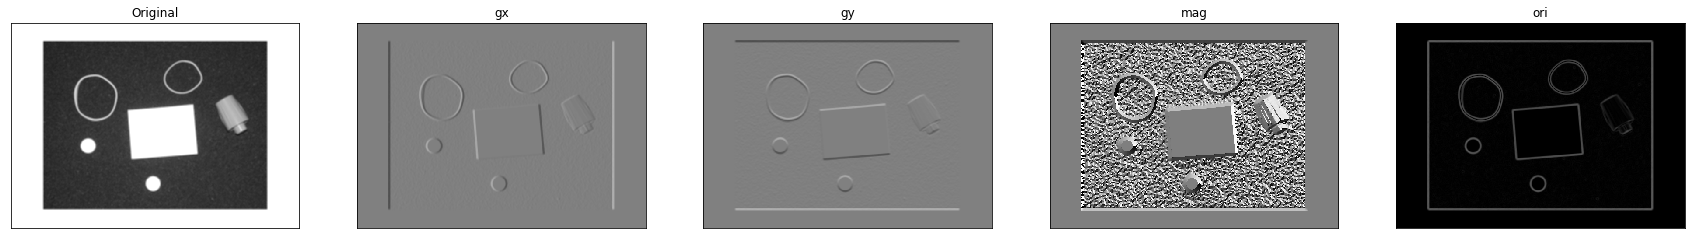

In [0]:
import numpy as np
from matplotlib import pyplot as plt

ngx, ngy, nmag, nori = soberOperator(blur)


# Plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
plt.subplot(151).imshow(blur, cmap='gray', vmin=0, vmax=255),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(152),plt.imshow(ngx, cmap='gray', vmin=0, vmax=255),plt.title('gx')
plt.xticks([]), plt.yticks([])
plt.subplot(153),plt.imshow(ngy, cmap='gray', vmin=0, vmax=255),plt.title('gy')
plt.xticks([]), plt.yticks([])
plt.subplot(154),plt.imshow(nmag, cmap='gray', vmin=0, vmax=255),plt.title('mag')
plt.xticks([]), plt.yticks([])
plt.subplot(155),plt.imshow(nori, cmap='gray', vmin=0, vmax=255),plt.title('ori')
plt.xticks([]), plt.yticks([])
plt.show()

2. (20pts) We want to extract the outer boundary of each object contained in one image. First, use edge() function (pre-defined or your own edge detector) to obtain the edge map. Then use imview() function to manually locate one pixel located on the outer boundary of each object. 

### Step 3: Non-maximum Suppression
![alt text](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/nms.jpg)
A full scan of image is done to remove any unwanted pixels which may not constitute the edge. At every pixel,  pixel is checked if it is a local maximum in its neighborhood in the direction of gradient. 

As shown in the image, on the vertical direction, point `A` is on ethe edge and point `b` and `C` are in the gradient directions, so point `A` is checked comparing with `B` and `C` to see if it forms a local maximum. If so, it is considered for next stage, otherwise, it is suppressed(to zero).

In [0]:
# Implement Non-maximum suppression
def maximum(det, phase):
  gmax = np.zeros(det.shape)
  for i in range(gmax.shape[0]):
    for j in range(gmax.shape[1]):
      if phase[i][j] < 0:
        phase[i][j] += 360

      if ((j+1) < gmax.shape[1]) and ((j-1) >= 0) and ((i+1) < gmax.shape[0]) and ((i-1) >= 0):
        # 0 degrees
        if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
          if det[i][j] >= det[i][j + 1] and det[i][j] >= det[i][j - 1]:
            gmax[i][j] = det[i][j]
        # 45 degrees
        if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
          if det[i][j] >= det[i - 1][j + 1] and det[i][j] >= det[i + 1][j - 1]:
            gmax[i][j] = det[i][j]
        # 90 degrees
        if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
          if det[i][j] >= det[i - 1][j] and det[i][j] >= det[i + 1][j]:
            gmax[i][j] = det[i][j]
        # 135 degrees
        if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
          if det[i][j] >= det[i - 1][j - 1] and det[i][j] >= det[i + 1][j + 1]:
            gmax[i][j] = det[i][j]
  return gmax

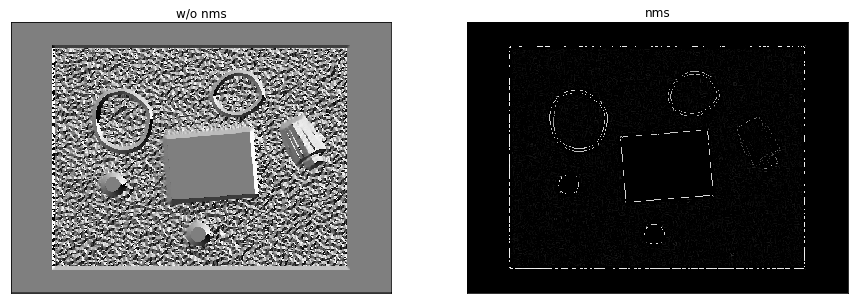

In [0]:
ori_phase = ori*180/np.pi
nms_mag = maximum(mag, ori_phase)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
# cv2_imshow(normalize(nms_mag))
plt.subplot(121).imshow(nmag, cmap='gray', vmin=0, vmax=255),plt.title('w/o nms')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(normalize(nms_mag), cmap='gray', vmin=0, vmax=255),plt.title('nms')
plt.xticks([]), plt.yticks([])
plt.show()

### Step 4: Hysteresis Thresholding
Set a threshold `minVAl`  and `maxVal`. For pixels in $[maxVal,\inf]$ are sure to be edges and pixels in $[-\inf, minVal]$ are sure to be non-edges. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity to ``sure-edge`` pixels. 

[link text](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/hysteresis.jpg)
The edge A is above the maxVal, so considered as “sure-edge”. Although edge C is below maxVal, it is connected to edge A, so that also considered as valid edge and we get that full curve. But edge B, although it is above minVal and is in same region as that of edge C, it is not connected to any “sure-edge”, so that is discarded. So it is very important that we have to select minVal and maxVal accordingly to get the correct result. 

This stage also removes small pixels noises on the assumption that edges are long lines. So what we finally get is strong edges in the image, and it also tries to make the line more connected.



In [0]:
#Implement Thresholding with connected component. 
# First, mark the range
def thresholding(im):
    thres  = np.zeros(im.shape)
    strong = 1.0
    weak   = 0.5
    mmax = np.max(im)
    lo, hi = 0.1 * mmax, 0.8 * mmax
    strongs = []
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            px = im[i][j]
            if px >= hi:
                thres[i][j] = strong
                strongs.append((i, j))
            elif px >= lo:
                thres[i][j] = weak
    return thres, strongs
# Second, through DFS, any visited pixels will be the final
class tracking:
    def __init__(self, tr):
        self.im = tr[0]
        strongs = tr[1]

        self.vis = np.zeros(self.im.shape, bool)
        self.dx = [1, 0, -1,  0, -1, -1, 1,  1]
        self.dy = [0, 1,  0, -1,  1, -1, 1, -1]
        for s in strongs:
            if not self.vis[s]:
                self.dfs(s)
        for i in range(self.im.shape[0]):
            for j in range(self.im.shape[1]):
                self.im[i, j] = 1.0 if self.vis[i, j] else 0.0

    def dfs(self, origin):
        q = [origin]
        while len(q) > 0:
            s = q.pop()
            self.vis[s] = True
            self.im[s] = 1
            for k in range(len(self.dx)):
                for c in range(1, 16):
                    nx, ny = s[0] + c * self.dx[k], s[1] + c * self.dy[k]
                    if self.exists(nx, ny) and (self.im[nx, ny] >= 0.5) and (not self.vis[nx, ny]):
                        q.append((nx, ny))
        pass

    def exists(self, x, y):
        return x >= 0 and x < self.im.shape[0] and y >= 0 and y < self.im.shape[1]

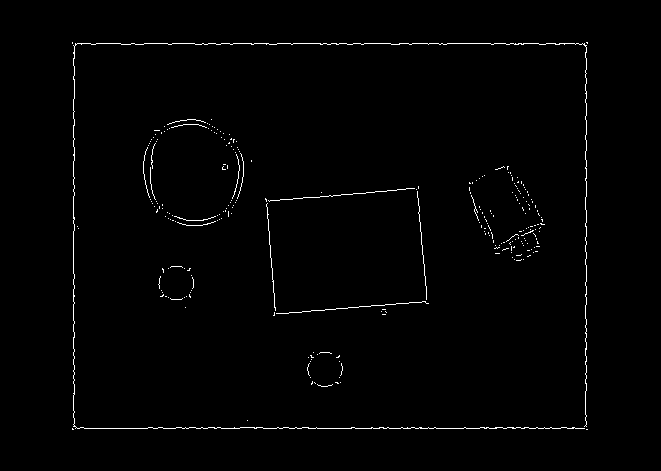

In [0]:
thres = thresholding(nms_mag)
edge = tracking(thres).im
cv2_imshow(edge*255)

### OpenCV Canny()

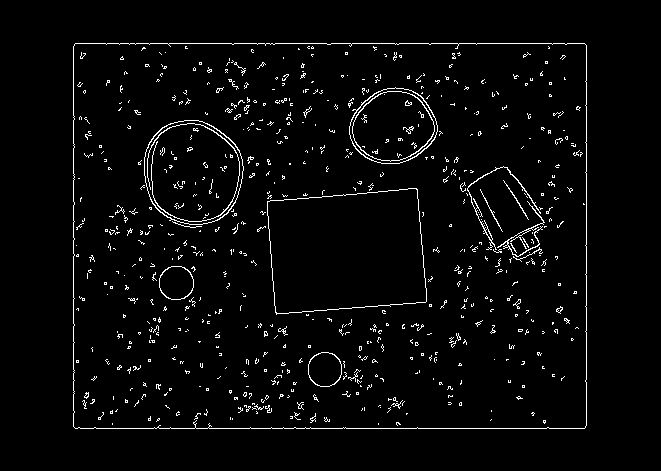

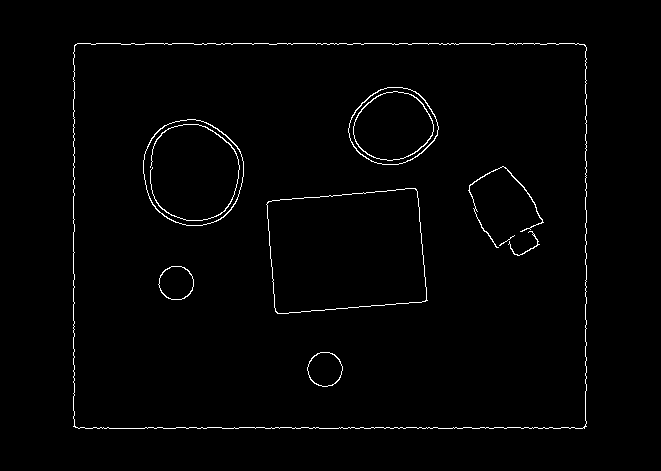

4225


In [0]:
# Implement Canny Edge detector using open cv 
edges = cv2.Canny(image,100,200)
edges_blur = cv2.Canny(blur,100,200) # 100, 200 are the first and second threshold for hysteresis thresholding
cv2_imshow(edges)
cv2_imshow(edges_blur)
print(np.sum(edges_blur!= 0))

Next, apply any technique you can come up with to trace the boundary edge pixels. Try to get a boundary as complete and accurate as possible: it is OK if your results are not perfect (see below). Plot the final boundary. you are able to detect and trace for each object. Discuss the success, failure, and possible ways for improvement in the report.
Note that boundary tracing is a non-trivial problem, involving many complicated issues such as noise, broken boundaries, ambiguous locations and directions, among others. Thus, do not worry if you are not able to get a ‘perfect’ result — we just want to see how hard you tried.
Do not use built-in functions such as ‘bwtraceboundary()’ provided by Matlab image processing library. The idea is for you to gain familiarity with the algorithm through the experiments in this homework.

### Moore Neighbor Contour Tracing

This is to find the outer boundary. First, define moore neigborhood:

![alt text](http://www.imageprocessingplace.com/downloads_V3/root_downloads/tutorials/contour_tracing_Abeer_George_Ghuneim/Figure1.gif). 

Second, the algorithm will find a **Start** boundary pixel, then start to apply the following algorithm
```
Set B to be empty.
Find the start pixel, s, of P is found.
Insert s in B.
Set the current boundary point p to s i.e. p=s
Backtrack i.e. move to the pixel from which s was entered.
Set c to be the next clockwise pixel in M(p).
While c not equal to s do

   If c is black

    insert c in B
    set p=c
    backtrack (move the current pixel c to the pixel from which p was entered)

   else

    advance the current pixel c to the next clockwise 
```

Worth to mention is the stopping criterion, we use Jacob's stopping criterion, which stops when visiting the start pixel the second time in the same manner as the first time.

In [0]:
# Moore tracing
class MooreTracing():
  def __init__(self, I):
    self.moore_neighbor = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)] #p8, p1, p2, p3, p4, p5, p6, p7
    # make the moore_neigbor a loop, can either use linked list, or just i%8
    self.I = np.array(I, dtype=np.bool)
    self.h, self.w = I.shape[0], I.shape[1]
    self.o = np.zeros(self.I.shape, dtype=np.int8)
    
  def findIndex(self, neig, cur):
    di, dj = neig[0] - cur[0], neig[1] - cur[1]
    for i in range(8):
      mi, mj = self.moore_neighbor[i]
      if di == mi and dj == mj:
        return i
    return -1
    
    

  # I need to be 1 and 0, which is segment or just boundary 
  def findMooreNeighbor(self, p, s):
    '''
    s: indicate the starting position in moore_neighbor
    '''
    count = 0
    while count < 8:
      idx = (s + count) % 8
      di, dj = self.moore_neighbor[idx]
      i, j = di+ p[0], dj + p[1]
      count += 1
      if i >= self.h or i < 0 or j >= self.w or j < 0:
        continue
      else:
        c = (i, j)
        return c
      
  def findPreviousMooreNeighbor(self, p, s):
    '''
    s: indicate the starting position in moore_neighbor
    '''
    count = 8
    while count > 0:
      idx = (s + count) % 8
      di, dj = self.moore_neighbor[idx]
      i, j = di+ p[0], dj + p[1]
      count -= 1
      if i >= self.h or i < 0 or j >= self.w or j < 0:
        continue
      else:
        c = (i, j)
        return c

  def findStart(self):
    pre, start = (-1, -1), (-1, -1) # previous and start pixel
#     for j in range(self.w):
#       for i in range(self.h-1, -1, -1):  
    for i in range(self.h):
      for j in range(self.w):
        if self.I[i,j] == 1 and self.o[i,j] ==0:
          start = (i, j)
          return pre, start
        else:
          pre = (i, j)
    return pre, start
      
      
  def mooreTracing(self):
    
    
    pre, start = self.findStart()
    if start[0] == -1:
      print('No actually boundary found')
      return False
    else:
      print('find boundary')
    self.o[start[0], start[1]] = 1
    p = start #current boundary pixel  
    c = pre# self.findMooreNeighbor(p, s=0)  # pixel to consider next
    idx = self.findIndex(pre, start)
    print('idx', idx)
    print(start,'p', p, 'c', c, self.I[c[0], c[1]]) 
    
    #idx = 0
    count = 0
    count_start = 0
    circle = 0
    buffer = [c] #
    while True: #count<4000:#count_start < 2: #count_start < 2:#c!=start:#p!= pre or c != start:
      if c == pre and p==start:
        count_start+=1
      count+=1
      circle = 0
      pre, start = c, p
      while circle < 8: 
        if self.I[c[0], c[1]] == 1: # if it is black, backtrack
          self.o[c[0], c[1]] = 1
          if idx == 0:
            idx = 7
          else:
            idx -= 1
          p, c = c, self.findPreviousMooreNeighbor(p, idx)
        else:
          #print('mark 2', c, idx) # move to the next position
          idx += 1
          if idx >= 8:
            idx %= 8
          c = self.findMooreNeighbor(p, idx)
        circle += 1
  
      if p == start:
        return True
        break
    return True
  def run(self):
    count = 0
    while self.mooreTracing():
      if count == 10:
        break
      count += 1
      pass
    
      
      
  

(471, 661)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 1077375
2


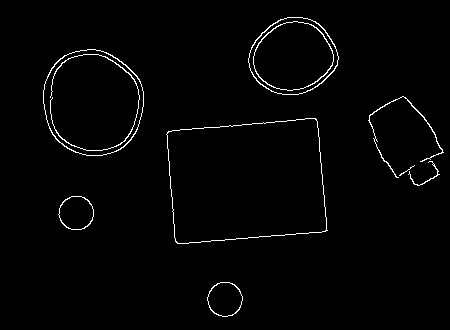

[[0 0 0]
 [0 1 1]
 [0 0 0]]
find boundary
idx 7
(1, 1) p (1, 1) c (1, 0) False
No actually boundary found


[[0 0 0]
 [0 1 1]
 [0 0 0]]


In [0]:
# first cut off the outside boundary
print(edges_blur.shape)
print(edges_blur, np.sum(edges_blur))
a = np.array([[0,0,0,0,0,0], [0,0,1,1,1,0],[0,0,1,0,1,0],[0,0,1,1,1,0], [0,0,0,0,0,0]])
a = np.array([[0,0,0],[0,1,1],[0,0,0]])
edges_blur = np.array(edges_blur!=0, dtype=np.int8)
#edges = np.zeros((300, 500), dtype=np.int8)
edges = edges_blur[70:400, 100:550]
print(np.sum(a))
cv2_imshow(edges*255)
print(a)
m = MooreTracing(a)
m.run()
o = m.o
cv2_imshow(o*255)
print(o)

To trace the boundary, we have to use segmentation label . The above edge detection shows gaps--non-continuity, occlusion and so on. Therefore, hough transform might be a better choice to get the boundary.

## Corner Point Detection, 20pts

Implement your own Harris corner detector to automatically identify corner points in an image. Your implementation should take an 2D image I as an input and compute corner responses for each pixel. Take the points of local maxima (within a radius r) of the response.

Because edges are hard to match and track, thus we move forward with corner points to do image alignment. 
* In the region around the corner in the image, gradient has two or more dominant gradients.
* Corners are repeatable and distinctive
### Harris Corner Detection

In [0]:
img_2 = load_image('2.png', mode='gray')

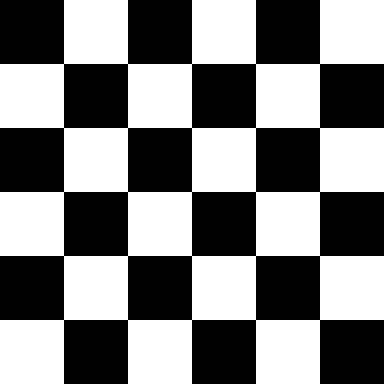

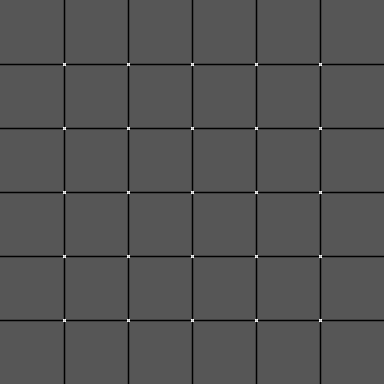

In [0]:
dst = normalize(cv2.cornerHarris(img_2,2,3,0.04))
cv2_imshow(img_2)
cv2_imshow(dst)

In [0]:
def harrisCornerDetector(I, window_size, k = 0.04, threshold=10000,  mode='same' ):
  # step 1, Ix, Iy, and M matrix
  ks = window_size
  #Ix, Iy, _, _ = soberOperator(I)
  Iy, Ix = np.gradient(I)
  Ixx, Iyy, Ixy = Ix**2, Iy**2, Ix*Iy
  # Define the window weight matrix
  ##wM = gauss_kernel(ks)
  wM = np.ones((window_size, window_size))
  # the process of finding corners are similar to conv2d
  pad_shape = ((0, 0), (0, 0)) # left, right, up down
  if mode == 'full':
    pad_size = ks-1
    pad_shape = ((pad_size, pad_size), (pad_size, pad_size))
  elif mode == 'same':
    pad_size = (ks-1) // 2
    pad_shape = ((pad_size, pad_size), (pad_size, pad_size))
  pI = np.pad(I, pad_shape, 'constant')
  pxx, pxy, pyy = np.pad(Ixx, pad_shape, 'constant'), np.pad(Ixy, pad_shape, 'constant'), np.pad(Iyy, pad_shape, 'constant')
  out_shape = (pxx.shape[0]-ks+1,  pxx.shape[1]-ks+1)
  output_array = np.zeros(out_shape)

  for i in range(out_shape[0]):
    for j in range(out_shape[1]):
      Sxx = np.sum(pxx[i:i+ks, j:j+ks]*wM)
      Syy = np.sum(pyy[i:i+ks, j:j+ks]*wM)
      Sxy = np.sum(pxy[i:i+ks, j:j+ks]*wM)
      # the matrix looks like [Sxx, Sxy], [Sxy, Syy]
      # Use the harris corner response function
      det = (Sxx*Syy) - (Sxy**2)
      trace = Sxx + Syy
      r = det - k*(trace**2)
      output_array[i, j] = 150 if r > threshold else pI[i,j]
  return output_array

(384, 384) (384, 384) (386, 386) (384, 384)


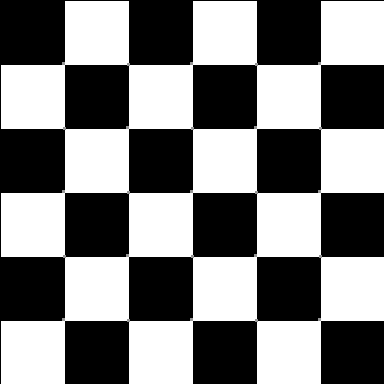

In [0]:
corners = harrisCornerDetector(img_2, window_size=3)
cv2_imshow(corners)

## Hough Transform, 50pts

The purpose of this component is to get familiar with the Hough transform for shape detection. You will need to implement the Hough transform on your own. The built-in functions such as hough() in Matlab are not allowed.


1. (20pts) Write a program to automatically identify straight lines in an image: lines = myHoughLine (imBW, n), where imBW is a binary image and n is the desired number of lines (in order of voting importance). If there are not enough n lines in an image, return as many as your implementation detected. Test with n = 5, and plot your lines along with a few images in your report.

We have our points and we try to fit a few lines to approximate them. Say $y = mx+c$. 
### Parameter space
In the space of $m, c$, we have $c = y-mx$. When at the $x, y$ space, there is a line that has all points on it. Correspondingly, in the parameter space--**Cartesian coordinate system**, they have the same $m, c$, meaning they intersect at the same point. Therefore, instead of working on the $x,y$ space and to approximate them with a uncertain number of lines, we switch to the parameter space, and use **Voting mechanism**. In this space, it has the following cons:
* The parameter domain is unbounded.
* When the line is vertice in $x, y$ space, $m$ becomes infinite big. 

### Hough Space
An alternative is the **polar representation**.
\begin{equation}
p = x\cos(\theta) + y \sin(\theta)
\end{equation}
with axis of $\theta, p$. The pros include:
* $\theta$ is bounded into $[0, 360]$. Because it is periodic, on the half $[180, 360]$ is going to vote the same distribution as $[0, 180]$. Therefore, we only need $[0, 180]$ is enough.

In [0]:
!ls

1.png  2-1.jpg	2-2.jpg  sample_data


In [0]:
from collections import defaultdict
import heapq
def myHoughLine(edges, n):
  lines = []
  h, w = edges.shape
  #acc = np.zeros((180, diag), dtype=np.int16)
  acc = defaultdict(int)
  for i in range(h):#y
    for j in range(w): # x
      if edges[i, j] == 0:
        continue
      for d in range(180):
        theta = d*np.pi/180
        p = i*np.sin(theta) + j * np.cos(theta)
        acc[d, int(p)] += 1

  # choose the top n
  q = [(-value, key) for key, value in acc.items()]
  heapq.heapify(q)
  for i in range(n):
    if q:
      lines.append(heapq.heappop(q)[1])
      
  return lines
    
  

In [0]:
# Plot lines on images
def plot_lines(I, lines):
  image = np.copy(I)
  for ang, rho in lines:
    theta = ang*np.pi/180
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(image,(x1,y1),(x2,y2),(150),2)
  return image
    
    

In [0]:
# Load image
from google.colab.patches import cv2_imshow
image = load_image('2-1.jpg')
#blur_3 = cv2.GaussianBlur(image,(3, 3),1)
edges_3 = cv2.Canny(image, 50, 150,apertureSize = 3)
#cv2_imshow(edges_3) 
num = 20
lines = myHoughLine(edges_3, num)


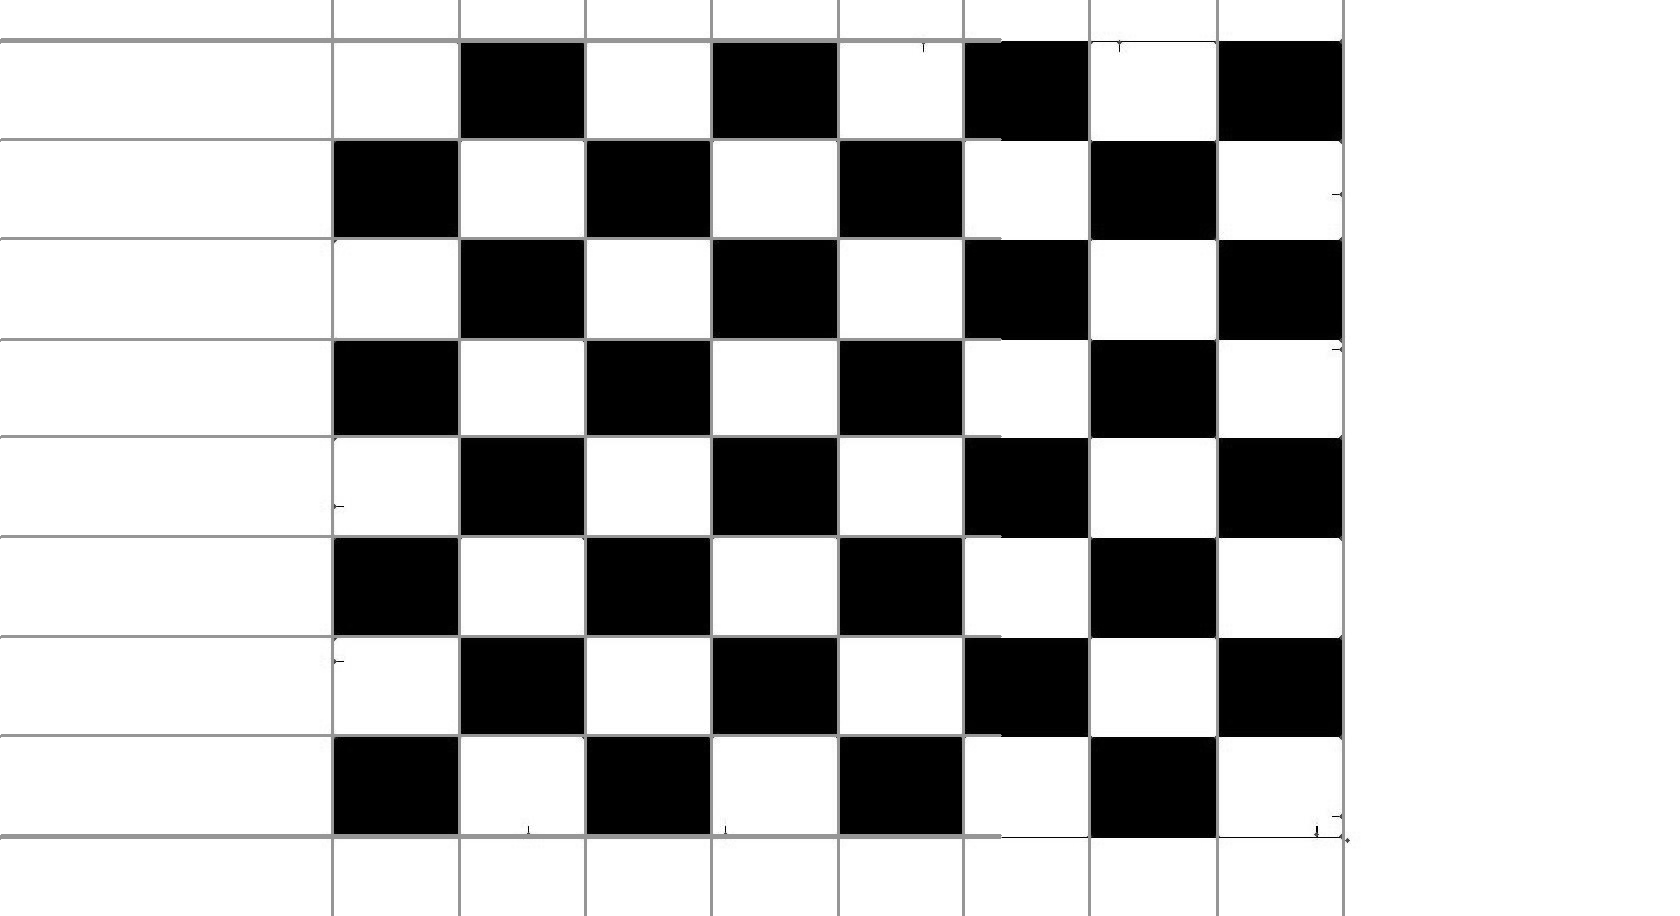

In [0]:
hough_image = plot_lines(image, lines)
#print(lines)
cv2_imshow(hough_image)

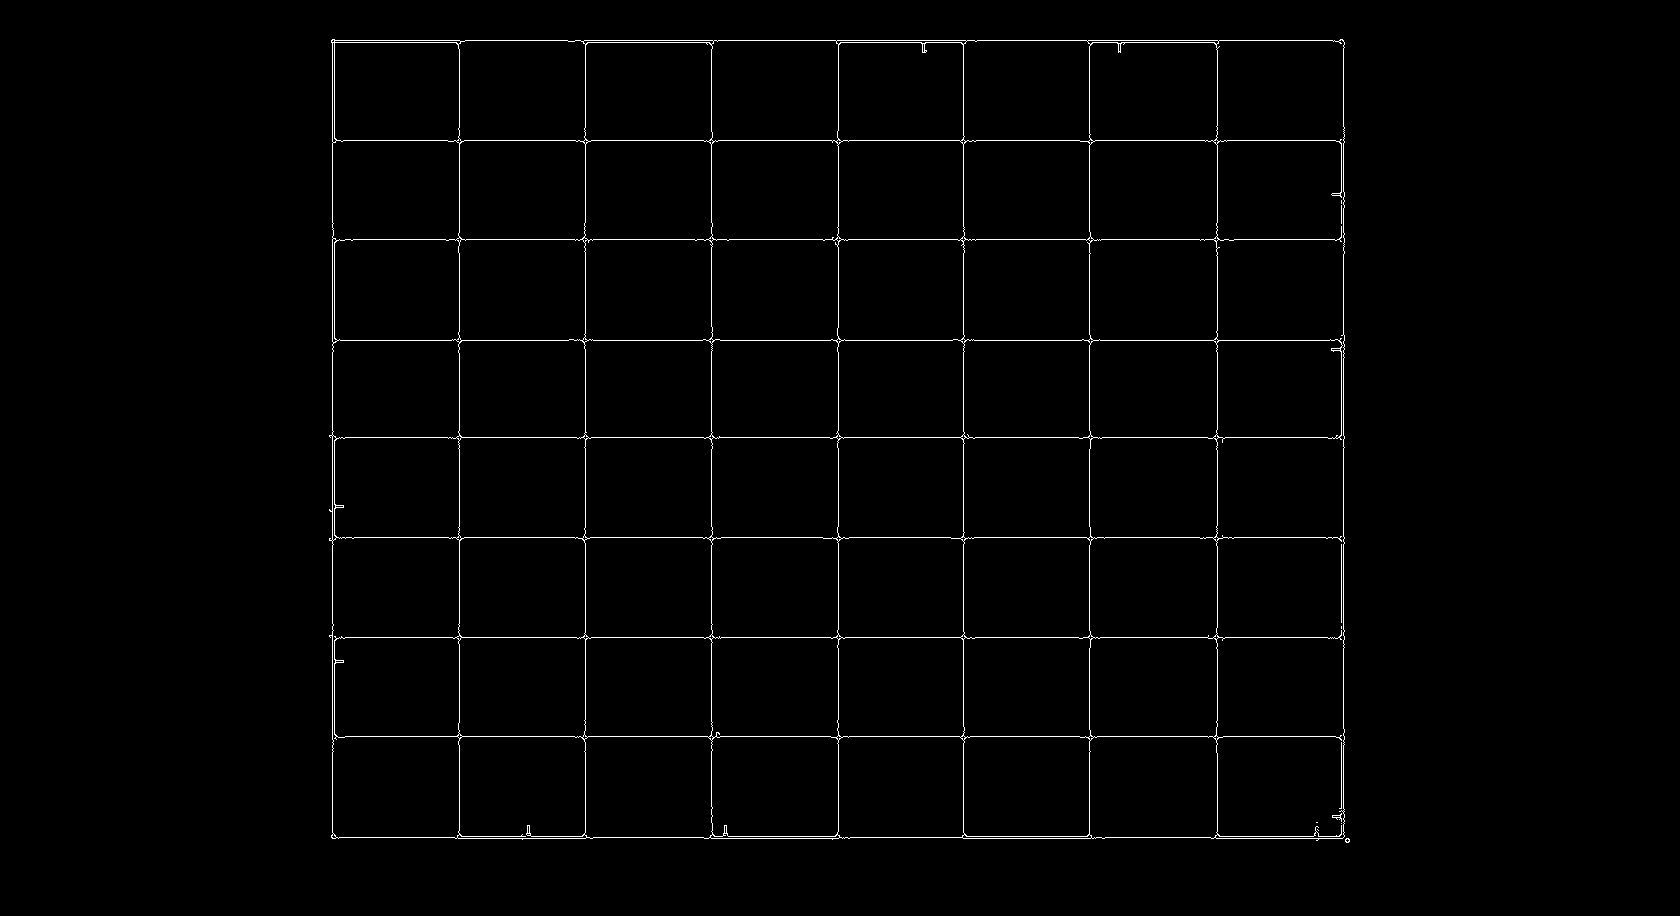

(916, 1680) (916, 1680) <class 'numpy.ndarray'>


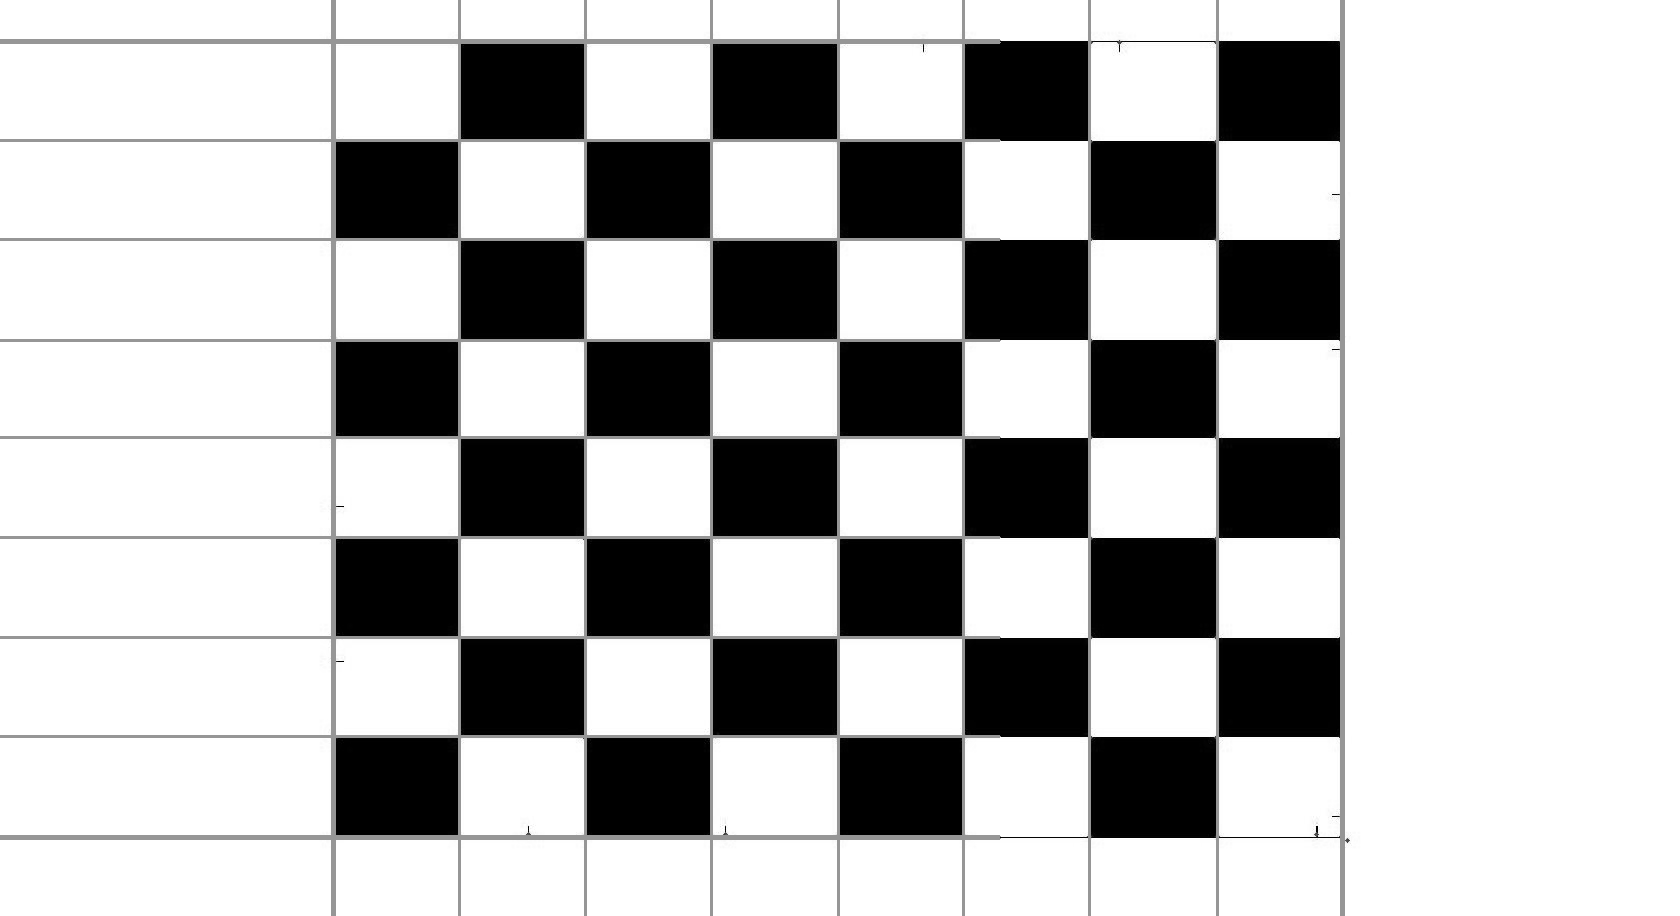

In [0]:
# Load image
from google.colab.patches import cv2_imshow
image = load_image('2-1.jpg')
#blur_3 = cv2.GaussianBlur(image,(3, 3),1)
edges_3 = cv2.Canny(image, 50, 150,apertureSize = 3)
cv2_imshow(edges_3) 
print(image.shape, edges_3.shape, type(edges_3))
#edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges_3,1,np.pi/180,300)
#print(lines, lines.shape)
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    image=cv2.line(image,(x1,y1),(x2,y2),(150),2)

hough_lines = cv2.imwrite('houghlines3.jpg',image)
cv2_imshow(image)

2. (30pts) If you haven’t already, read “Generalizing the Hough transform to detect arbitrary shapes (Ballard, 1981)” and review “Lecture Note 5” for Hough transform from class. Write a program to find (roughly) circular objects of a specific radius in a binary image. You should write two func- tions, yourcellvar = myHoughCircleTrain(imBW, c, ptlist), and myHoughCircleTest(imBWnew, yourcellvar). The binary image imBW supplied to the first function will have a single circular object. Further, c will be the (given) reference point, and for convenience we will also provide you an ordered list of boundary points in ptlist. Use this information to construct whatever data structure you want (and save all tabular data necessary for the subsequent step), and return it as a cell array variable, yourcellvar. That is, yourcellvar is the object myHoughCircleTrain should return. Next, this will be passed directly to myHoughCircleTest where you will identify circular objects in a novel image, imBWnew. Your function should report the reference points for the top two circles identified. You will receive full credit if your reference point is close enough.

Test with your own images and discuss your results with these images in your report.

### Concepts
A circle can be describled as $(x-a)^2+(y-b)^2=r^2$, pointing out three variables, center $a, b$ and radius $r$.

It can be denoted as:
\begin{align}
x &= a + r\cos(\theta)\\
&\rightarrow \\
r &= \frac{x-a}{\cos(\theta)}
\end{align}
Similarly,
\begin{align}
y &= b + r\sin(\theta)\\
&\rightarrow \\
r &= \frac{y-b}{\sin(\theta)}\\
\end{align}
The hough space is 3-d with center $a, b$ and radius $r$.

Assume $r$ is known, we have space $a, b$:
\begin{align}
a &= x - r\cos(\theta) \\
b &= y - r\sin(\theta)
\end{align}

$\theta \in [0, 360)$.

In [0]:
# Read from mat file
from scipy.io import loadmat
x = loadmat('train.mat')
c = x['c'][0]
ptlist = x['ptlist'][0]
#print(c, ptlist)

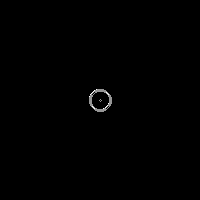

In [0]:
img = load_image('train.png', mode='gray')
# draw c 
cv2.circle(img,center=(c[0],c[1]),radius=1,color=(150),thickness=1) #(image, center_coordinates, radius, color, thickness)
for p in (ptlist):
  x, y = p[0]
  cv2.circle(img,center=(x,y),radius=1,color=(150),thickness=1)
cv2_imshow(img)

In [0]:
# Implement hough circle detector without training
def myUnsupervisedHoughCircle(imBW, rmin, rmax, steps, threshold):
  '''
  imBW: binary image where 1 represents edge
  rmin: minmum circle allowed to detect
  rmax:
  steps: total steps for \theta
  threshold: [0, 1] to set threshold for ratio of detected points of a circle
  '''
  # Compute points for r, and r. theta to speed up
  points = []
  for r in range(rmin, rmax + 1):
      for t in range(steps):
          points.append((r, int(r * np.cos(2 * np.pi * t / steps)), int(r * np.sin(2 * np.pi * t / steps))))
          
  acc = defaultdict(int)
   
  # Vote through scanning edge points
  h, w = imBW.shape
  for y in range(h):
    for x in range(w):
      if imBW[y, x] == 0:
        continue
      for r, dx, dy in points:
        a = x - dx
        b = y - dy
        acc[a, b, r] += 1
        
 # Sort and fiter circles
  circles = []
  for k, v in sorted(acc.items(), key=lambda i: -i[1]):
      x, y, r = k
      # Make sure a same circle wont be draw twice
      if v / steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
          circles.append((x, y, r))
  return circles
        

In [0]:
def plot_circles(img, circles):
    cimg = np.copy(img)
    for i in circles:
      # draw the outer circle
      cv2.circle(cimg,(i[0],i[1]),i[2],150,2)
      # draw the center of the circle
      cv2.circle(cimg,(i[0],i[1]),2,150,3)
    return cimg

In [0]:
img = load_image('test.png', mode='gray')

edges_test = cv2.Canny(img, 50, 150,apertureSize = 3)

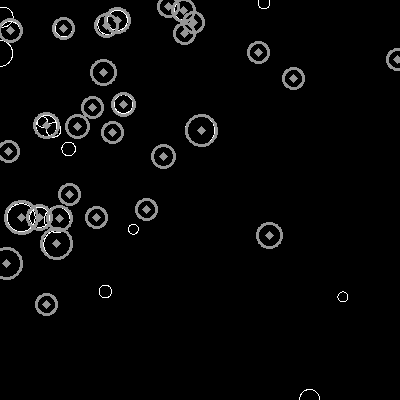

In [0]:
circles = myUnsupervisedHoughCircle(edges_test, rmin=10, rmax=50, steps=100, threshold=0.4)
cimg = plot_circles(img, circles)
cv2_imshow(cimg)

In [0]:
# Detect circles with openCV
import cv2
import numpy as np

img = load_image('train.png', mode='gray')

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=10,maxRadius=50)

## Reference
1. https://github.com/sebasvega95/Canny-edge-detector
2. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html
3. Moore Neighbor Tracing: http://www.imageprocessingplace.com/downloads_V3/root_downloads/tutorials/contour_tracing_Abeer_George_Ghuneim/moore.html
4. Harris Corner with Math: http://www.cs.cornell.edu/courses/cs4670/2015sp/lectures/lec07_harris_web.pdf
5. [plot graph](http://fooplot.com/#W3sidHlwZSI6MCwiZXEiOiIxKmNvcyh4KSsyKnNpbih4KSIsImNvbG9yIjoiIzAwMDAwMCJ9LHsidHlwZSI6MTAwMH1d)
6. [Hough Line Transformer](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)
7. [Other implementations](https://www.codingame.com/playgrounds/38470/how-to-detect-circles-in-images)
